#### Import all the Libraries used

In [1]:
import sys
!{sys.executable} -m  pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

#for visualisations of graphs
import matplotlib.pyplot as plt
%matplotlib inline

#for datetime object
from datetime import datetime

#statsmodel libraires
from statsmodels.tsa.stattools import adfuller                 #To check stationarity in Time Series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX         #SARIMA
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.holtwinters import ExponentialSmoothing   #Holt's Winter Method

#ARIMA
from pmdarima import auto_arima

#Skit-Learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#Keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [3]:
import warnings                   # To ignore the warnings
warnings.filterwarnings("ignore")

In [5]:
#Import the monthly rainfall data(from January 1901 to December 1970) for two locations:
# 1. AJMER
ajmer_data  = pd.read_csv("/ajmer_rainfall_data.csv")
# 2. JAIPUR
jaipur_data = pd.read_csv("/jaipur_rainfall_data.csv")

In [6]:
ajmer_data.head()

,YEAR,MONTH,Datetime,Rainfall
0,1901,Jan,01-01-1901,5.082
1,1901,Feb,01-02-1901,0.769
2,1901,Mar,01-03-1901,0.182
3,1901,Apr,01-04-1901,0.291
4,1901,May,01-05-1901,3.470


In [7]:
jaipur_data.tail()

,YEAR,MONTH,Datetime,Rainfall
835,1970,Aug,01-08-1970,332.986
836,1970,Sep,01-09-1970,134.737
837,1970,Oct,01-10-1970,0.325
838,1970,Nov,01-11-1970,0.000
839,1970,Dec,01-12-1970,0.000


In [8]:
#Drop year and month column
ajmer_data  = ajmer_data.drop(['YEAR', 'MONTH'], axis=1)
jaipur_data = jaipur_data.drop(['YEAR', 'MONTH'], axis=1)

In [9]:
#Check object types
ajmer_data.dtypes
jaipur_data.dtypes

Datetime     object
Rainfall    float64
dtype: object

In [10]:
#convert object dtype to datetime
ajmer_data['Datetime'] = pd.to_datetime(ajmer_data.Datetime,format='%d-%m-%Y')
jaipur_data['Datetime'] = pd.to_datetime(jaipur_data.Datetime,format='%d-%m-%Y')

In [11]:
#create months column
for i in (ajmer_data, jaipur_data):
    i['month']=i.Datetime.dt.month

In [12]:
#check object type
ajmer_data.dtypes
jaipur_data.dtypes

Datetime    datetime64[ns]
Rainfall           float64
month                int32
dtype: object

In [13]:
ajmer_data.head()

,Datetime,Rainfall,month
0,1901-01-01,5.082,1
1,1901-02-01,0.769,2
2,1901-03-01,0.182,3
3,1901-04-01,0.291,4
4,1901-05-01,3.470,5


In [14]:
jaipur_data.tail()

,Datetime,Rainfall,month
835,1970-08-01,332.986,8
836,1970-09-01,134.737,9
837,1970-10-01,0.325,10
838,1970-11-01,0.000,11
839,1970-12-01,0.000,12


### Plot cummulative monthly rainfall

<Axes: xlabel='month'>

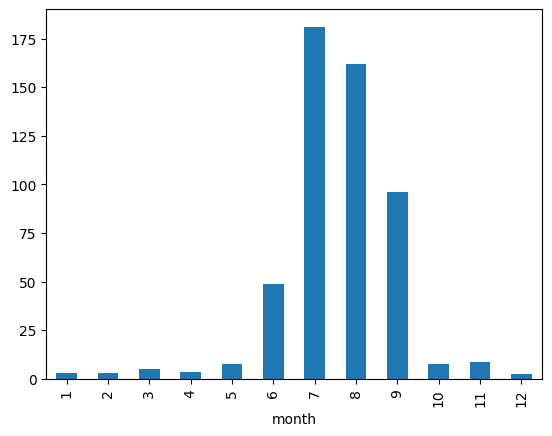

In [15]:
ajmer_data.groupby('month')['Rainfall'].mean().plot.bar()

<Axes: xlabel='month'>

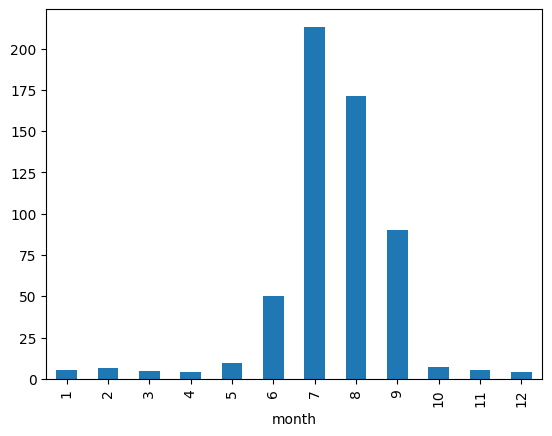

In [16]:
jaipur_data.groupby('month')['Rainfall'].mean().plot.bar()

#### Both the location found to have highest rainfall during JULY and AUGUST

In [17]:
#Create timestamp
ajmer_data.Timestamp = pd.to_datetime(ajmer_data.Datetime,format='%d-%m-%Y')
ajmer_data.index = ajmer_data.Timestamp
jaipur_data.Timestamp = pd.to_datetime(jaipur_data.Datetime,format='%d-%m-%Y')
jaipur_data.index = jaipur_data.Timestamp

In [18]:
ajmer_data  = ajmer_data.drop(['Datetime','month'], axis=1)
jaipur_data = jaipur_data.drop(['Datetime','month'], axis=1)

In [19]:
ajmer_data.head()

,Rainfall
Datetime,
1901-01-01,5.082
1901-02-01,0.769
1901-03-01,0.182
1901-04-01,0.291
1901-05-01,3.470


In [20]:
jaipur_data.tail()

,Rainfall
Datetime,
1970-08-01,332.986
1970-09-01,134.737
1970-10-01,0.325
1970-11-01,0.000
1970-12-01,0.000


# Visualisations

## Ajmer

<Axes: xlabel='Datetime'>

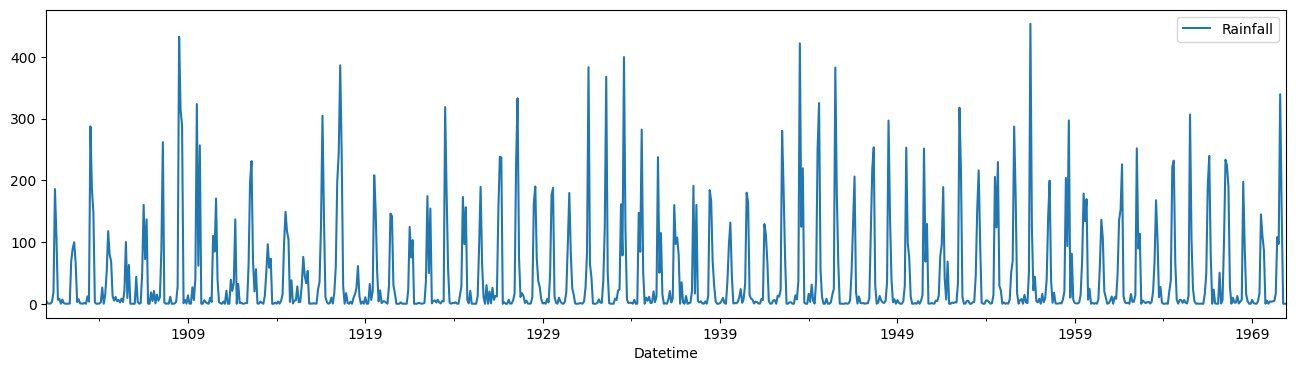

In [21]:
ajmer_data.plot(figsize=(16,4))

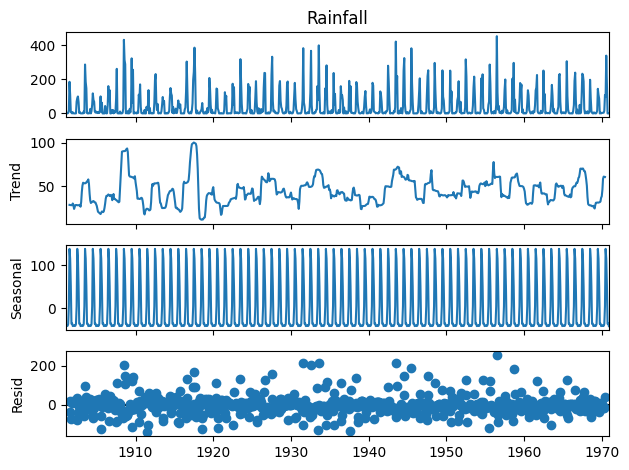

In [22]:
seasonal_decompose(ajmer_data['Rainfall'], model='additive').plot();

### Autocorrelation plot

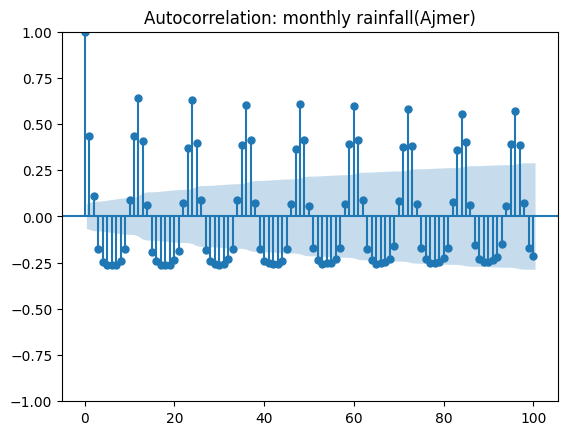

In [23]:
title = 'Autocorrelation: monthly rainfall(Ajmer)'
lags = 100
plot_acf(ajmer_data,title=title,lags=lags);

## Jaipur

<Axes: xlabel='Datetime'>

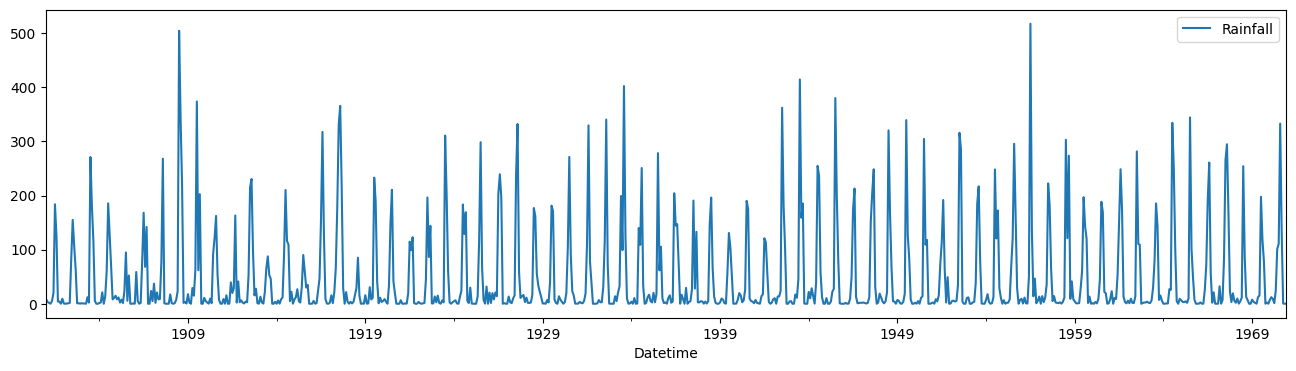

In [24]:
jaipur_data.plot(figsize=(16,4))

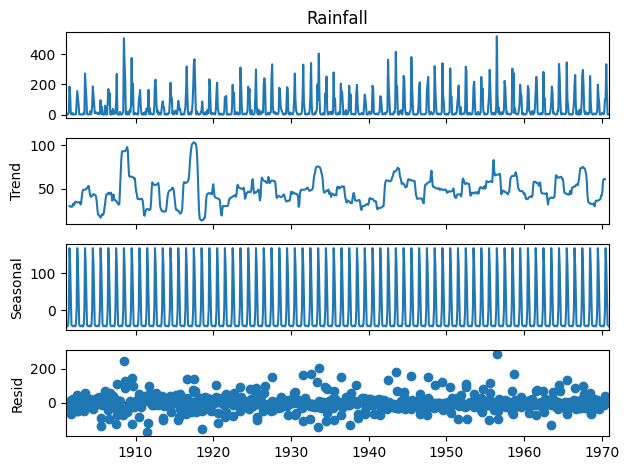

In [25]:
seasonal_decompose(jaipur_data['Rainfall'], model='additive').plot();

### Autocorrelation plot

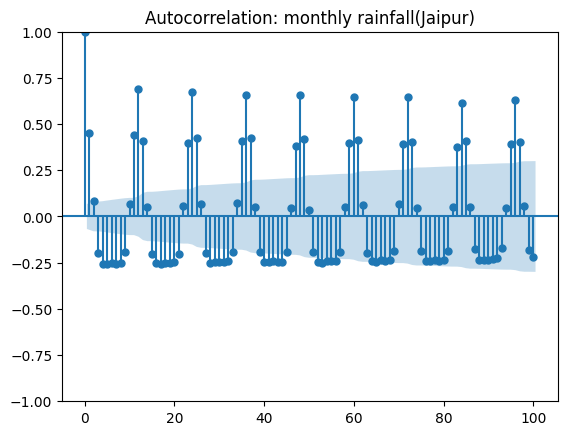

In [26]:
title = 'Autocorrelation: monthly rainfall(Jaipur)'
lags = 100
plot_acf(jaipur_data,title=title,lags=lags);

#### From the visualisaiton data seems to be seasonal.

### Let's check Stationary of the Time Series using Augmented Dickey-Fuller Test

#### Null hypothesis is that datasets are not stationary

In [27]:
print('Augmented Dickey-Fuller Test on Ajmer Rainfall Data')
dftest = adfuller(ajmer_data['Rainfall'],autolag='AIC')
dftest

Augmented Dickey-Fuller Test on Ajmer Rainfall Data


(-7.983073684534113,
 2.592033150166127e-12,
 21,
 818,
 {'1%': -3.438369485934381,
  '5%': -2.865079774912655,
  '10%': -2.5686548826226527},
 8875.282134374687)

In [28]:
print('Augmented Dickey-Fuller Test on Jaipur Rainfall Data')
dftest = adfuller(jaipur_data['Rainfall'],autolag='AIC')
dftest

Augmented Dickey-Fuller Test on Jaipur Rainfall Data


(-8.149674880455146,
 9.77253499759357e-13,
 21,
 818,
 {'1%': -3.438369485934381,
  '5%': -2.865079774912655,
  '10%': -2.5686548826226527},
 8904.248513465602)

#### Since p-value<0.05, we reject the null hypothesis
#### Hence both the datasets are stationary.

In [ ]:
### Train Test Split

In [29]:
len(ajmer_data)
len(jaipur_data)

840

In [30]:
# Set two year for testing

train_a = ajmer_data.iloc[:816]
test_a = ajmer_data.iloc[816:]

train_j = jaipur_data.iloc[:816]
test_j = jaipur_data.iloc[816:]

# MODELS

## 1. ARIMA

### Checks the best fit model ARIMA to be used along with its parameter

In [31]:
stepwise_fit = auto_arima(ajmer_data['Rainfall'], start_p=0, start_q=0,
                          max_p=6, max_q=3, m=12,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=3.68 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9718.228, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=9249.891, Time=3.39 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=9416.911, Time=1.77 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9947.627, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=9545.688, Time=0.15 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=9128.242, Time=6.29 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=8971.445, Time=11.74 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=4.26 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=15.42 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=12.10 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=6.51 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=11.94 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=13.43 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=8992.5

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  840
Model:             SARIMAX(1, 0, 0)x(2, 0, [1], 12)   Log Likelihood               -4479.722
Date:                              Thu, 13 Jun 2024   AIC                           8971.445
Time:                                      08:13:46   BIC                           8999.845
Sample:                                  01-01-1901   HQIC                          8982.330
                                       - 12-01-1970                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4013      0.361      1.111      0.267      -0.307       1.110
ar.L1          0.0586      0.020      2.863      0.004       0.018       0.099
ar.S.L12       0.9518      0.022     42.973      0.000       0.908       0.995
ar.S.L24       0.0343      0.020      1.727      0.084      -0.005       0.073
ma.S.L12      -0.8538      0.018    -48.167      0.000      -0.889      -0.819
sigma2      2434.3336     65.688     37.059      0.000    2305.587    2563.080
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              3280.36
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                             2.05
Prob(H) (two-sided):                  0.01   Kurtosis:                        11.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
stepwise_fit = auto_arima(jaipur_data['Rainfall'], start_p=0, start_q=0,
                          max_p=6, max_q=3, m=12,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=3.40 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9825.937, Time=0.09 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=9255.201, Time=1.64 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=9459.211, Time=1.63 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=10060.361, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=9637.891, Time=0.16 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=9132.435, Time=7.22 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=10.37 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=5.59 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=9142.770, Time=4.38 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=9131.318, Time=9.68 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=9254.416, Time=2.47 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=8945.052, Time=13.48 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=5.12 sec
 ARIMA(2,0,0)(2,0,2)[12] intercept  

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  840
Model:             SARIMAX(2, 0, 0)x(2, 0, [1], 12)   Log Likelihood               -4465.526
Date:                              Thu, 13 Jun 2024   AIC                           8945.052
Time:                                      08:19:23   BIC                           8978.186
Sample:                                  01-01-1901   HQIC                          8957.751
                                       - 12-01-1970                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3267      0.250      1.305      0.192      -0.164       0.817
ar.L1          0.0681      0.020      3.443      0.001       0.029       0.107
ar.L2          0.0582      0.026      2.211      0.027       0.007       0.110
ar.S.L12       0.9545      0.021     45.027      0.000       0.913       0.996
ar.S.L24       0.0333      0.019      1.724      0.085      -0.005       0.071
ma.S.L12      -0.8797      0.019    -45.985      0.000      -0.917      -0.842
sigma2      2401.2118     65.335     36.753      0.000    2273.158    2529.265
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              4211.99
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             2.14
Prob(H) (two-sided):                  0.01   Kurtosis:                        13.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Therefore we will use Seasonal-ARIMA model = SARIMAX(0, 0, 0)x(1, 0, 1, 12) for Ajmer Rainfall data
#### and Seasonal-ARIMA model = SARIMAX(1, 0, 0)x(1, 0, 1, 12) for Jaipur Rainfall data

### AJMER

In [33]:
#Fitting our model on Train set

model = SARIMAX(train_a['Rainfall'],order=(0,0,0),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                   Rainfall   No. Observations:                  816
Model:             SARIMAX(1, 0, [1], 12)   Log Likelihood               -4337.727
Date:                    Thu, 13 Jun 2024   AIC                           8681.454
Time:                            08:19:57   BIC                           8695.567
Sample:                        01-01-1901   HQIC                          8686.871
                             - 12-01-1968                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9997      0.000   5091.857      0.000       0.999       1.000
ma.S.L12      -0.9647      0.010    -94.227      0.000      -0.985      -0.945
sigma2      2300.7142     53.589     42.932      0.000    2195.681    2405.748
===================================================================================
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):              3234.52
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             2.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
# Obtain predicted values

start=len(train_a)
end=len(train_a)+len(test_a)-1
predicted_a = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,0,0)(1,0,1,12) Predictions')

In [35]:
# Compare predictions to expected values
for i in range(len(predicted_a)):
    print(f"predicted={predicted_a[i]}, expected={test_a['Rainfall'][i]}")

predicted=3.051231346181552, expected=6.052
predicted=2.4380054840736385, expected=0.872
predicted=6.369756053701523, expected=0.312
predicted=2.9169851290609388, expected=0.0
predicted=7.300690235952739, expected=4.085
predicted=44.986526126025844, expected=17.161
predicted=190.9695676684186, expected=144.558
predicted=160.94835755860242, expected=109.526
predicted=96.82387843461714, expected=86.345
predicted=8.648696708667359, expected=0.0
predicted=9.718009892597344, expected=5.077
predicted=2.406780727050684, expected=0.0
predicted=3.0503696211805393, expected=3.647
predicted=2.4373169455657795, expected=3.23
predicted=6.3679571150374015, expected=3.967
predicted=2.916161317711321, expected=4.309
predicted=7.2986283840027575, expected=15.802
predicted=44.97382108669147, expected=107.894
predicted=190.9156342781831, expected=96.931
predicted=160.90290272157287, expected=339.508
predicted=96.79653355405064, expected=152.583
predicted=8.646254154388622, expected=0.019
predicted=9.7152

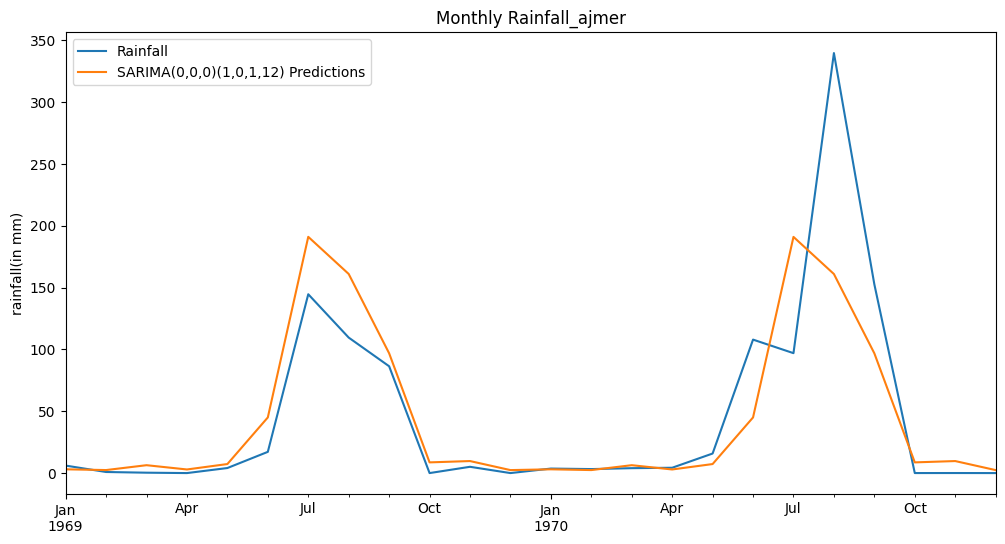

In [36]:
# Plot predictions against known values
title = 'Monthly Rainfall_ajmer'
ylabel='rainfall(in mm)'
xlabel=''

ax = test_a['Rainfall'].plot(legend=True,figsize=(12,6),title=title)
predicted_a.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

#### Evaluation

In [37]:
error = rmse(test_a['Rainfall'], predicted_a)
print(f'RMSE Error for ARIMA on AJMER rainfall: {error}')

RMSE Error for ARIMA on AJMER rainfall: 47.39475614503746


### JAIPUR

In [38]:
#Fitting our model on Train set

model = SARIMAX(train_j['Rainfall'],order=(1,0,0),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                             Rainfall   No. Observations:                  816
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood               -4323.522
Date:                              Thu, 13 Jun 2024   AIC                           8655.044
Time:                                      08:20:56   BIC                           8673.861
Sample:                                  01-01-1901   HQIC                          8662.266
                                       - 12-01-1968                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0644      0.020      3.277      0.001       0.026       0.103
ar.S.L12       0.9997      0.000   5239.694      0.000       0.999       1.000
ma.S.L12      -0.9576      0.009   -104.357      0.000      -0.976      -0.940
sigma2      2222.5983     49.545     44.860      0.000    2125.492    2319.705
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):              3660.74
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             1.87
Prob(H) (two-sided):                  0.01   Kurtosis:                        12.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
# Obtain predicted values

start=len(train_j)
end=len(train_j)+len(test_j)-1
predicted_j = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,0,0)(1,0,1,12) Predictions')

In [40]:
# Compare predictions to expected values
for i in range(len(predicted_j)):
    print(f"predicted={predicted_j[i]}, expected={test_j['Rainfall'][i]}")

predicted=4.777937686636913, expected=7.506
predicted=4.792874808842506, expected=3.423
predicted=5.494311804622195, expected=1.838
predicted=3.266715499774053, expected=0.095
predicted=9.294534274576613, expected=12.314
predicted=44.430799267708444, expected=15.245
predicted=230.08174937281495, expected=197.733
predicted=176.3558612092086, expected=118.314
predicted=92.54875334257878, expected=77.801
predicted=8.87183995252893, expected=0.005
predicted=6.304080408914639, expected=2.188
predicted=3.8327832176618526, expected=0.0
predicted=5.0234486795887605, expected=7.151
predicted=4.807305969030755, expected=12.081
predicted=5.493634642854768, expected=8.905
predicted=3.265769140334545, expected=1.194
predicted=9.291657867127167, expected=24.183
predicted=44.41702904762362, expected=101.271
predicted=230.01043985897618, expected=110.573
predicted=176.3012030122115, expected=332.986
predicted=92.52006958888956, expected=134.737
predicted=8.86909029180427, expected=0.325
predicted=6.30

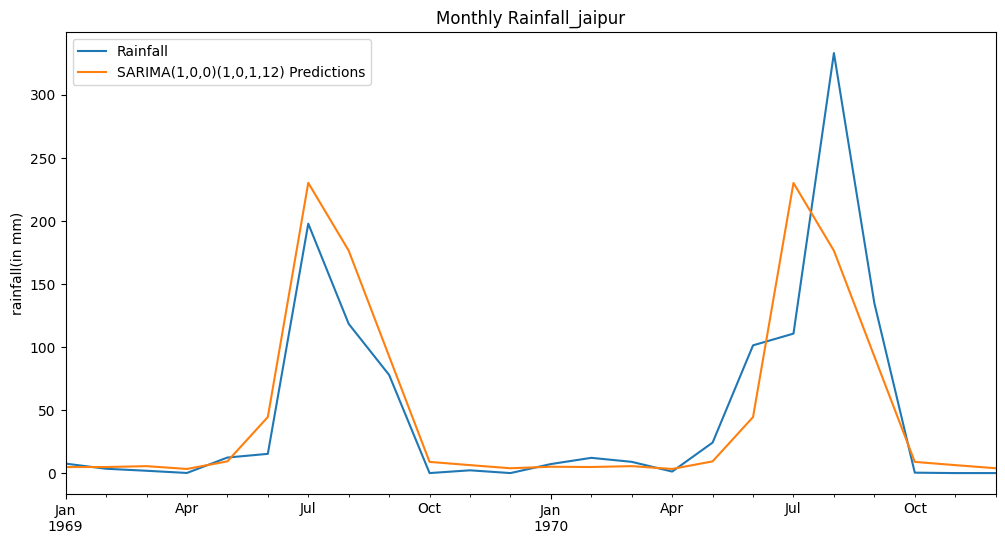

In [41]:
# Plot predictions against known values
title = 'Monthly Rainfall_jaipur'
ylabel='rainfall(in mm)'
xlabel=''

ax = test_j['Rainfall'].plot(legend=True,figsize=(12,6),title=title)
predicted_j.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

#### Evaluation

In [42]:
error = rmse(test_j['Rainfall'], predicted_j)
print(f'RMSE Error for ARIMA on Jaipur rainfall: {error}')

RMSE Error for ARIMA on Jaipur rainfall: 45.59299520258068


## 2. Deep Learning (LSTM)

### AJMER

In [43]:
#Scaled the data

scaler = MinMaxScaler()
scaler.fit(train_a)
scaled_train = scaler.transform(train_a)
scaled_test = scaler.transform(test_a)

In [44]:
# define generator
n_input = 24
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [45]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
# fit model
model.fit_generator(generator,epochs=50)

Epoch 1/50
792/792 [==============================] - 16s 18ms/step - loss: 0.0265
Epoch 2/50
792/792 [==============================] - 14s 18ms/step - loss: 0.0186
Epoch 3/50
792/792 [==============================] - 14s 17ms/step - loss: 0.0164
Epoch 4/50
792/792 [==============================] - 16s 21ms/step - loss: 0.0153
Epoch 5/50
792/792 [==============================] - 14s 18ms/step - loss: 0.0152
Epoch 6/50
792/792 [==============================] - 14s 18ms/step - loss: 0.0148
Epoch 7/50
792/792 [==============================] - 14s 18ms/step - loss: 0.0146
Epoch 8/50
792/792 [==============================] - 16s 20ms/step - loss: 0.0143
Epoch 9/50
792/792 [==============================] - 16s 21ms/step - loss: 0.0136
Epoch 10/50
792/792 [==============================] - 15s 19ms/step - loss: 0.0136
Epoch 11/50
792/792 [==============================] - 15s 19ms/step - loss: 0.0138
Epoch 12/50
792/792 [==============================] - 15s 18ms/step - loss: 0.0135
E

In [48]:
model.history.history.keys()

dict_keys(['loss'])

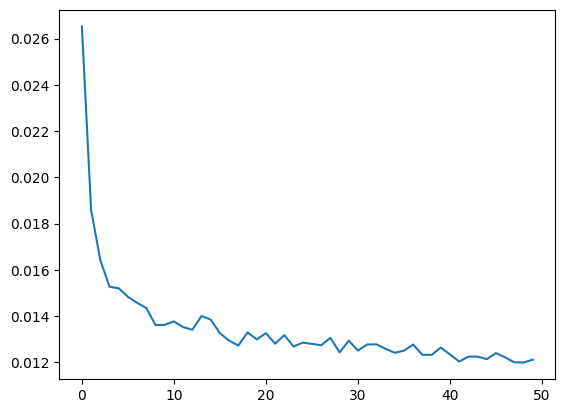

In [49]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [50]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_a)):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    test_predictions.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 27ms/step


In [51]:
test_predictions

[array([0.00391597], dtype=float32),
 array([0.00298886], dtype=float32),
 array([0.00426193], dtype=float32),
 array([0.00908922], dtype=float32),
 array([0.0115394], dtype=float32),
 array([0.04564654], dtype=float32),
 array([0.31292424], dtype=float32),
 array([0.3074316], dtype=float32),
 array([0.23317665], dtype=float32),
 array([0.01594168], dtype=float32),
 array([0.00118036], dtype=float32),
 array([0.0021195], dtype=float32),
 array([0.00174538], dtype=float32),
 array([0.00253], dtype=float32),
 array([0.00160442], dtype=float32),
 array([0.0044738], dtype=float32),
 array([0.00701971], dtype=float32),
 array([0.02739611], dtype=float32),
 array([0.34050676], dtype=float32),
 array([0.30177996], dtype=float32),
 array([0.1935792], dtype=float32),
 array([0.0163393], dtype=float32),
 array([0.0032278], dtype=float32),
 array([0.00465294], dtype=float32)]

In [52]:
true_predictions = scaler.inverse_transform(test_predictions)

In [53]:
test = test_a
test['Predictions'] = true_predictions

In [54]:
test

,Rainfall,Predictions
Datetime,,
1969-01-01,6.052,1.776736
1969-02-01,0.872,1.356091
1969-03-01,0.312,1.933703
1969-04-01,0.000,4.123917
1969-05-01,4.085,5.235599
1969-06-01,17.161,20.710520
1969-07-01,144.558,141.978420
1969-08-01,109.526,139.486332
1969-09-01,86.345,105.795743


<Axes: xlabel='Datetime'>

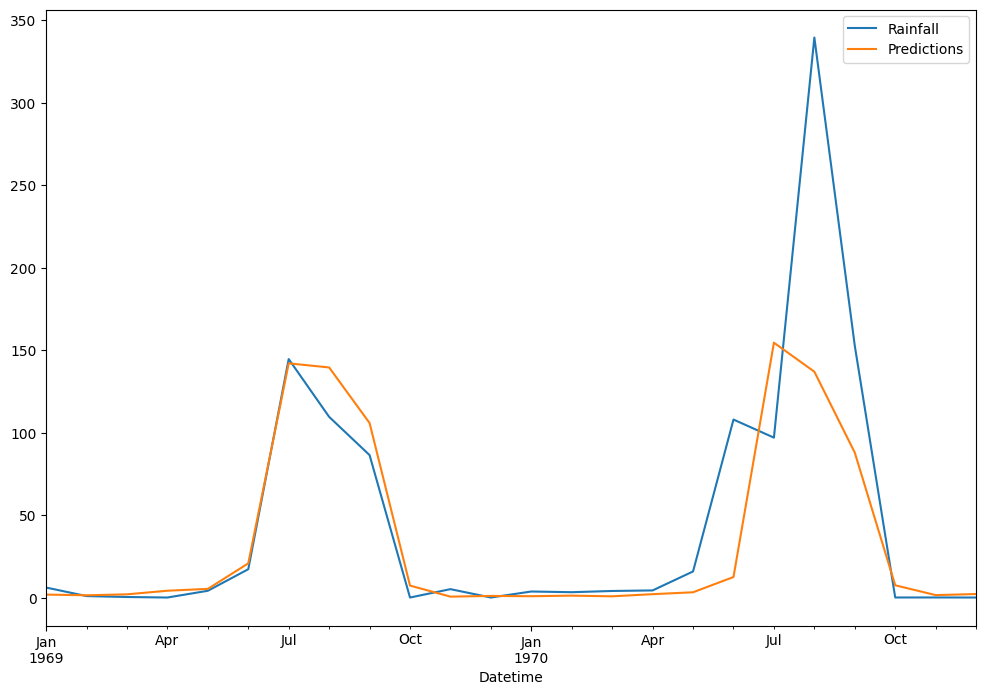

In [55]:
test.plot(figsize=(12,8))

#### Evaluation

In [56]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Rainfall'], test['Predictions'])
print(error)

49.71496197207189


### JAIPUR

In [57]:
#Scaled the data

scaler = MinMaxScaler()
scaler.fit(train_j)
scaled_train = scaler.transform(train_j)
scaled_test = scaler.transform(test_j)

In [58]:
# define generator
n_input = 24
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [59]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [60]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [61]:
# fit model
model.fit_generator(generator,epochs=50)

Epoch 1/50
792/792 [==============================] - 16s 18ms/step - loss: 0.0249
Epoch 2/50
792/792 [==============================] - 15s 18ms/step - loss: 0.0168
Epoch 3/50
792/792 [==============================] - 15s 18ms/step - loss: 0.0132
Epoch 4/50
792/792 [==============================] - 14s 18ms/step - loss: 0.0133
Epoch 5/50
792/792 [==============================] - 14s 18ms/step - loss: 0.0128
Epoch 6/50
792/792 [==============================] - 15s 19ms/step - loss: 0.0113
Epoch 7/50
792/792 [==============================] - 14s 18ms/step - loss: 0.0115
Epoch 8/50
792/792 [==============================] - 14s 18ms/step - loss: 0.0111
Epoch 9/50
792/792 [==============================] - 14s 18ms/step - loss: 0.0111
Epoch 10/50
792/792 [==============================] - 14s 18ms/step - loss: 0.0107
Epoch 11/50
792/792 [==============================] - 14s 18ms/step - loss: 0.0106
Epoch 12/50
792/792 [==============================] - 15s 19ms/step - loss: 0.0104
E

In [62]:
model.history.history.keys()

dict_keys(['loss'])

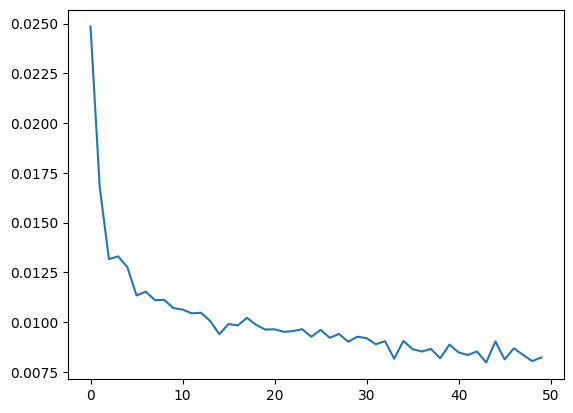

In [63]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [64]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_j)):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    test_predictions.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 44ms/step


In [65]:
test_predictions

[array([0.01207298], dtype=float32),
 array([0.00871667], dtype=float32),
 array([0.00821204], dtype=float32),
 array([0.01058516], dtype=float32),
 array([0.022104], dtype=float32),
 array([0.05687847], dtype=float32),
 array([0.46653336], dtype=float32),
 array([0.3235089], dtype=float32),
 array([0.18319306], dtype=float32),
 array([0.0226595], dtype=float32),
 array([0.01897831], dtype=float32),
 array([0.01784813], dtype=float32),
 array([0.0181167], dtype=float32),
 array([0.0163118], dtype=float32),
 array([0.01157184], dtype=float32),
 array([0.01217216], dtype=float32),
 array([0.02209324], dtype=float32),
 array([0.06623624], dtype=float32),
 array([0.47724235], dtype=float32),
 array([0.31031117], dtype=float32),
 array([0.12288013], dtype=float32),
 array([0.0153226], dtype=float32),
 array([0.01808111], dtype=float32),
 array([0.01705284], dtype=float32)]

In [66]:
true_predictions = scaler.inverse_transform(test_predictions)

In [67]:
test = test_j
test['Predictions'] = true_predictions

In [68]:
test

,Rainfall,Predictions
Datetime,,
1969-01-01,7.506,6.249132
1969-02-01,3.423,4.511863
1969-03-01,1.838,4.250657
1969-04-01,0.095,5.479016
1969-05-01,12.314,11.441315
1969-06-01,15.245,29.441035
1969-07-01,197.733,241.483734
1969-08-01,118.314,167.452406
1969-09-01,77.801,94.823108


<Axes: xlabel='Datetime'>

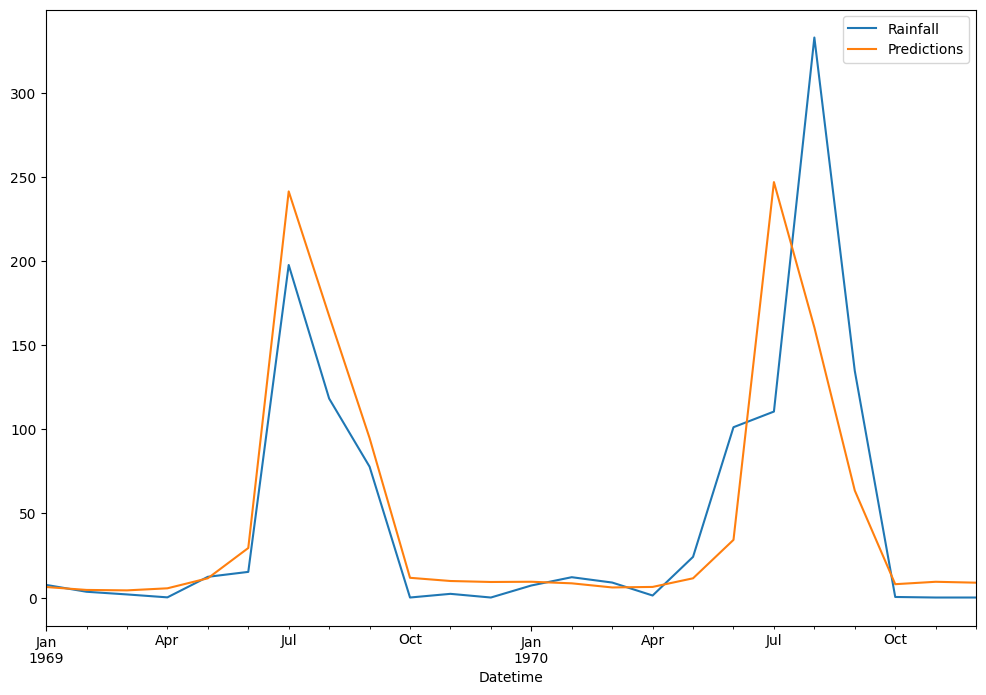

In [69]:
test.plot(figsize=(12,8))

In [70]:
test_a = test_a.drop(['Predictions'], axis=1)
test_j = test_j.drop(['Predictions'], axis=1)

#### Evaluation

In [71]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Rainfall'], test['Predictions'])
print(error)

51.41917648455477


## 3. Holt's Winter Method (Triple Exponential Smoothing)

### AJMER

In [72]:
ajmer_data.index.freq = 'MS'
ajmer_data.index

DatetimeIndex(['1901-01-01', '1901-02-01', '1901-03-01', '1901-04-01',
               '1901-05-01', '1901-06-01', '1901-07-01', '1901-08-01',
               '1901-09-01', '1901-10-01',
               ...
               '1970-03-01', '1970-04-01', '1970-05-01', '1970-06-01',
               '1970-07-01', '1970-08-01', '1970-09-01', '1970-10-01',
               '1970-11-01', '1970-12-01'],
              dtype='datetime64[ns]', name='Datetime', length=840, freq='MS')

In [73]:
fitted_model = ExponentialSmoothing(train_a['Rainfall'],trend='add',seasonal='add',seasonal_periods=12).fit()

In [74]:
test_predictions = fitted_model.forecast(24).rename('HW Forecast')

In [75]:
test_predictions

1969-01-01      1.831899
1969-02-01      1.417887
1969-03-01      5.890691
1969-04-01      2.059973
1969-05-01      6.741342
1969-06-01     44.033644
1969-07-01    192.269393
1969-08-01    159.165623
1969-09-01     94.910715
1969-10-01      7.143785
1969-11-01      7.986697
1969-12-01      1.060752
1970-01-01      1.587941
1970-02-01      1.173930
1970-03-01      5.646733
1970-04-01      1.816016
1970-05-01      6.497384
1970-06-01     43.789686
1970-07-01    192.025435
1970-08-01    158.921665
1970-09-01     94.666757
1970-10-01      6.899827
1970-11-01      7.742739
1970-12-01      0.816795
Freq: MS, Name: HW Forecast, dtype: float64

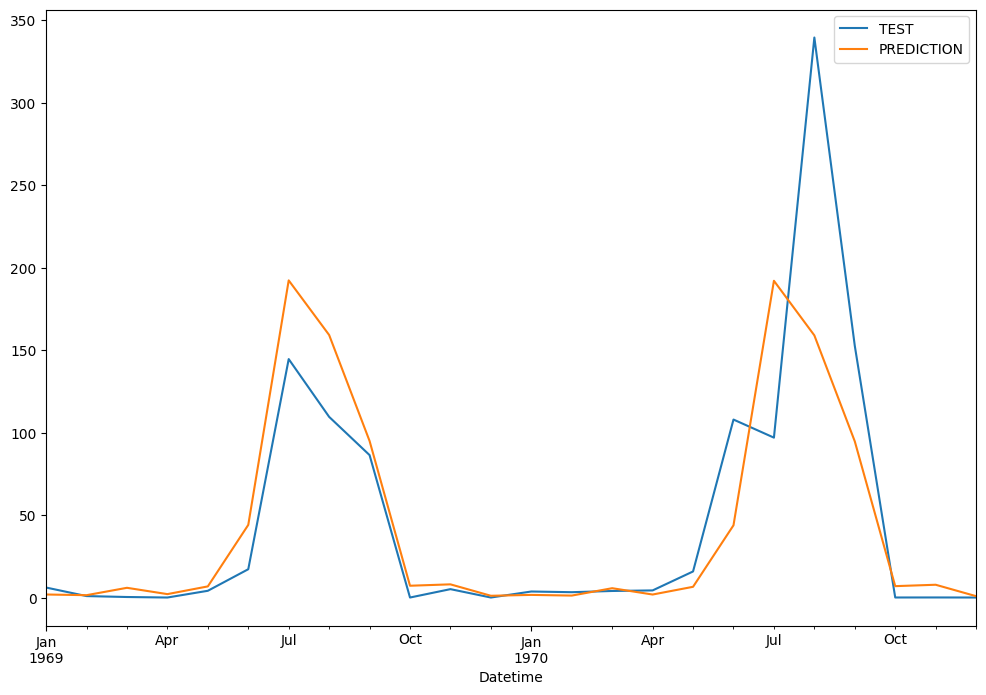

In [76]:
test_a['Rainfall'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION');

#### Evaluation

In [77]:
np.sqrt(mean_squared_error(test_a,test_predictions))

47.865525045245896

### JAIPUR

In [78]:
jaipur_data.index.freq = 'MS'
jaipur_data.index

DatetimeIndex(['1901-01-01', '1901-02-01', '1901-03-01', '1901-04-01',
               '1901-05-01', '1901-06-01', '1901-07-01', '1901-08-01',
               '1901-09-01', '1901-10-01',
               ...
               '1970-03-01', '1970-04-01', '1970-05-01', '1970-06-01',
               '1970-07-01', '1970-08-01', '1970-09-01', '1970-10-01',
               '1970-11-01', '1970-12-01'],
              dtype='datetime64[ns]', name='Datetime', length=840, freq='MS')

In [79]:
fitted_model = ExponentialSmoothing(train_j['Rainfall'],trend='add',seasonal='add',seasonal_periods=12).fit()

In [80]:
test_predictions = fitted_model.forecast(24).rename('HW Forecast')

In [81]:
test_predictions

1969-01-01      5.159267
1969-02-01      5.294184
1969-03-01      5.687677
1969-04-01      3.896153
1969-05-01      9.854553
1969-06-01     46.480442
1969-07-01    228.971443
1969-08-01    175.845200
1969-09-01     91.935674
1969-10-01      8.249584
1969-11-01      5.795458
1969-12-01      3.741916
1970-01-01      4.960718
1970-02-01      5.095635
1970-03-01      5.489128
1970-04-01      3.697604
1970-05-01      9.656005
1970-06-01     46.281893
1970-07-01    228.772894
1970-08-01    175.646651
1970-09-01     91.737125
1970-10-01      8.051035
1970-11-01      5.596910
1970-12-01      3.543367
Freq: MS, Name: HW Forecast, dtype: float64

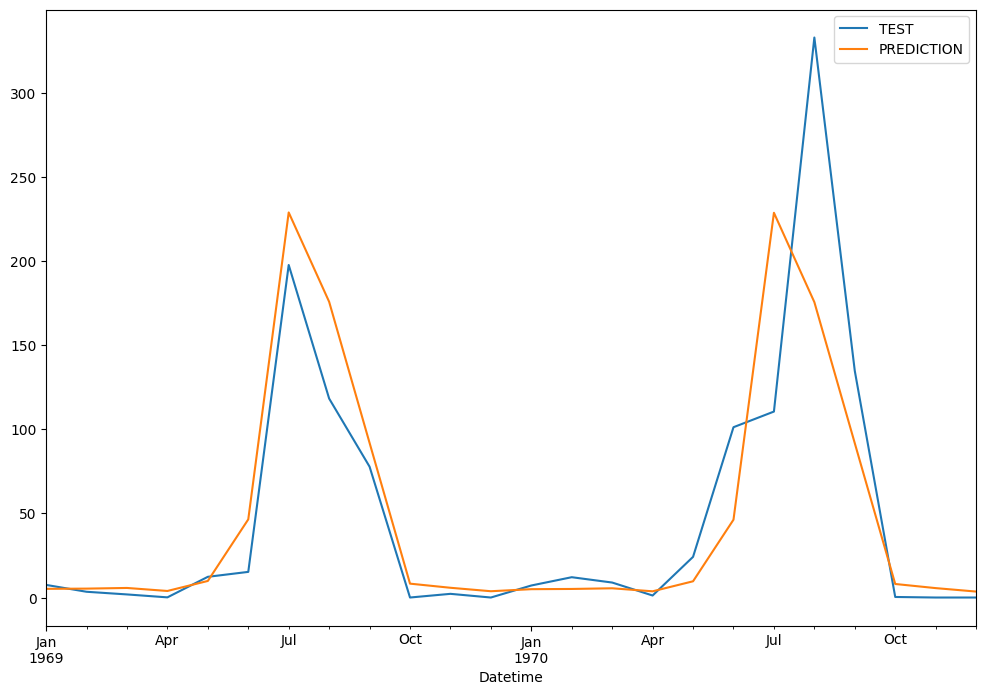

In [82]:
test_j['Rainfall'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION');

#### Evaluation

In [83]:
np.sqrt(mean_squared_error(test_j,test_predictions))

45.45430296268572

# RESULTS

## Based on the results,we will choose LSTM on Ajmer Data and ARIMA on Jaipur Data for our future rainfall forecasting

# Forecasting

#### Now we will train our model on all the data from Jan 1901 to Dec 1970

## AJMER (LSTM)

In [85]:
scaler = MinMaxScaler()
scaler.fit(ajmer_data)
scaled_data = scaler.transform(ajmer_data)

In [86]:
# define generator
n_input = 24
n_features = 1
generator = TimeseriesGenerator(scaled_data, scaled_data, length=n_input, batch_size=1)

In [87]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [88]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [89]:
# fit model
model.fit_generator(generator,epochs=50)

Epoch 1/50
816/816 [==============================] - 16s 18ms/step - loss: 0.0231
Epoch 2/50
816/816 [==============================] - 15s 18ms/step - loss: 0.0167
Epoch 3/50
816/816 [==============================] - 15s 18ms/step - loss: 0.0159
Epoch 4/50
816/816 [==============================] - 15s 19ms/step - loss: 0.0164
Epoch 5/50
816/816 [==============================] - 15s 19ms/step - loss: 0.0159
Epoch 6/50
816/816 [==============================] - 15s 18ms/step - loss: 0.0153
Epoch 7/50
816/816 [==============================] - 15s 18ms/step - loss: 0.0142
Epoch 8/50
816/816 [==============================] - 15s 19ms/step - loss: 0.0144
Epoch 9/50
816/816 [==============================] - 15s 19ms/step - loss: 0.0146
Epoch 10/50
816/816 [==============================] - 15s 18ms/step - loss: 0.0144
Epoch 11/50
816/816 [==============================] - 15s 18ms/step - loss: 0.0138
Epoch 12/50
816/816 [==============================] - 15s 18ms/step - loss: 0.0143
E

In [90]:
model.history.history.keys()

dict_keys(['loss'])

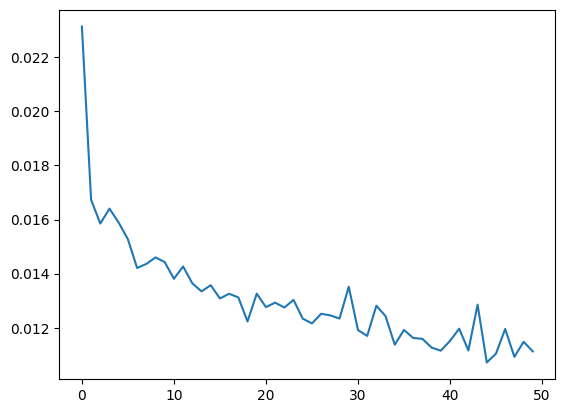

In [91]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [92]:
Forecasted_rainfall = []

first_eval_batch = scaled_data[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(1,361):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    Forecasted_rainfall.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 38ms/step


In [93]:
Rainfall_Ajmer = scaler.inverse_transform(Forecasted_rainfall)

In [94]:
Rainfall_Ajmer

array([[ -0.62471887],
       [  0.22578636],
       [  2.19559589],
       [  4.08715838],
       [ 11.68867983],
       [ 49.19916971],
       [217.64885644],
       [179.79003587],
       [ 92.88733625],
       [ 19.49955195],
       [  4.31119536],
       [  1.82547826],
       [  1.84231623],
       [  2.78656783],
       [  4.68872799],
       [  6.3258532 ],
       [  8.17810285],
       [ 39.14272527],
       [111.17593678],
       [158.85748491],
       [105.550526  ],
       [ 17.99169308],
       [  7.49315468],
       [  4.33869524],
       [  3.46047548],
       [  3.96463094],
       [  4.490046  ],
       [  6.16755563],
       [  8.90343376],
       [ 34.90591819],
       [157.72027779],
       [146.80997473],
       [ 95.79367645],
       [ 22.68074898],
       [  8.04262326],
       [  3.70828202],
       [  2.62166319],
       [  3.42311147],
       [  5.09311822],
       [  6.72271856],
       [  8.88233643],
       [ 34.84337666],
       [173.39619019],
       [141

## JAIPUR(ARIMA)

In [98]:
#Fitting our model on whole dataset

model = SARIMAX(jaipur_data['Rainfall'],order=(1,0,0),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                             Rainfall   No. Observations:                  840
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood               -4449.759
Date:                              Thu, 13 Jun 2024   AIC                           8907.518
Time:                                      09:16:40   BIC                           8926.451
Sample:                                  01-01-1901   HQIC                          8914.774
                                       - 12-01-1970                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0543      0.019      2.805      0.005       0.016       0.092
ar.S.L12       0.9998      0.000   6404.590      0.000       0.999       1.000
ma.S.L12      -0.9626      0.009   -107.379      0.000      -0.980      -0.945
sigma2      2216.5112     48.728     45.487      0.000    2121.005    2312.017
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              3724.57
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                             1.87
Prob(H) (two-sided):                  0.03   Kurtosis:                        12.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [99]:
# Obtain predicted values

start=len(jaipur_data)
end=len(jaipur_data)+360-1
Rainfall_Jaipur = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,0,0)(1,0,1,12) Predictions')

In [100]:
Rainfall_Jaipur

1971-01-01      5.049588
1971-02-01      5.207360
1971-03-01      5.385558
1971-04-01      3.226190
1971-05-01      9.965361
                 ...    
2000-08-01    177.950232
2000-09-01     92.512915
2000-10-01      8.030259
2000-11-01      5.799694
2000-12-01      3.561372
Freq: MS, Name: SARIMA(1,0,0)(1,0,1,12) Predictions, Length: 360, dtype: float64

In [101]:
Rainfall_Jaipur.to_csv('Jaipur_forecasted.csv',index=False)